In [34]:
import os
import torch
from torch.utils.data import Dataset, DataLoader

from glob import glob as glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import cv2

from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

# from skimage import transform
# from skimage.transform import resize
import torchio as tio

import wandb
import torch

import monai
from monai.networks.nets import UNet
from monai.transforms import Compose
from monai.visualize import plot_2d_or_3d_image
from monai.losses import DiceLoss

from utilities import save_checkpoint
from utilities import DiceScore
# from utilities import DiceLoss


In [35]:
my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_device

device(type='cpu')

In [36]:
wandb.login()

True

In [37]:
wandb.init(
    project="BrainTumor2018 Implementation",
    config={
        "epochs" : 15,
        "train_batch_size" : 1,
        "val_batch_size" : 1,
        "lr" : 0.001,
        "seed" : 42
    }
)

In [38]:
# Initialize SummaryWriter
model_name = '3DUNet'
writer = SummaryWriter(log_dir=f'./logs/{model_name}')


# Dataset

In [39]:
main_directory = "../data/train_minidata2021"
output_directory = "../data/train_minidata2021/processed_train"
main_directory_val = "../data/validation_minidata2021"
output_directory_val = "../data/validation_minidata2021/processed_val"

In [40]:
def load_nifty(directory, example_id, suffix):
    file_path = os.path.join(directory, example_id + "_" + suffix + ".nii.gz")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No such file or no access: '{file_path}'")
    return nib.load(file_path)


In [41]:
def load_channels(directory, example_id):
    flair = load_nifty(directory, example_id, "flair")
    t1 = load_nifty(directory, example_id, "t1")
    t1ce = load_nifty(directory, example_id, "t1ce")
    t2 = load_nifty(directory, example_id, "t2")
    return flair, t1, t1ce, t2


In [42]:
def prepare_nifty(d, output_dir):
    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header

    # Load data for each modality
    flair_data = get_data(flair)
    t1_data = get_data(t1)
    t1ce_data = get_data(t1ce)
    t2_data = get_data(t2)

    # Combine into a single volume
    combined_volume = np.stack([flair_data, t1_data, t1ce_data, t2_data], axis=3)

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the combined volume in the output directory
    img_path = os.path.join(output_dir, example_id + ".nii.gz")
    vol = nib.Nifti1Image(combined_volume, affine, header=header)
    nib.save(vol, img_path)

    # Process segmentation if available
    mask_path = ""
    seg_path = os.path.join(d, example_id + "_seg.nii.gz")
    if os.path.exists(seg_path):
        seg = nib.load(seg_path)
        affine, header = seg.affine, seg.header
        seg_data = get_data(seg, "uint8")
        seg_data[seg_data == 4] = 3  # Adjust labels if necessary
        seg = nib.Nifti1Image(seg_data, affine, header=header)
        mask_path = os.path.join(output_dir, example_id + "_seg.nii.gz")
        nib.save(seg, mask_path)

    return img_path, mask_path


In [43]:
def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0  # Handle edge cases
        return data
    return nifty.get_fdata().astype(np.uint8)
# Initialize lists to store paths
train_volume_path = []
train_segmentation_path = []


In [44]:
for subject_dir in os.listdir(main_directory):
    subject_path = os.path.join(main_directory, subject_dir)
    if os.path.isdir(subject_path):  # Check if it's a directory
        print(f"Processing {subject_path}...")
        try:
            # List the contents of the directory
            files = os.listdir(subject_path)
            print(f"Files in {subject_path}: {files}")
            
            img_path, mask_path = prepare_nifty(subject_path, output_directory)
            train_volume_path.append(img_path)
            train_segmentation_path.append(mask_path if mask_path else None)
        except FileNotFoundError as e:
            print(e)  # Print the error if any file is missing
        except Exception as e:
            print(f"An error occurred while processing {subject_path}: {e}")

# Convert lists to arrays
train_volume_path = np.array(train_volume_path)
train_segmentation_path = np.array(train_segmentation_path)

# Print the arrays
print("Train Volume Paths:", train_volume_path)
print("Train Segmentation Paths:", train_segmentation_path)


Processing ../data/train_minidata2021/BraTS2021_00366...
Files in ../data/train_minidata2021/BraTS2021_00366: ['BraTS2021_00366_t1ce.nii.gz', 'BraTS2021_00366_seg.nii.gz', 'BraTS2021_00366_t1.nii.gz', 'BraTS2021_00366_t2.nii.gz', 'BraTS2021_00366_flair.nii.gz']
Processing ../data/train_minidata2021/BraTS2021_00045...
Files in ../data/train_minidata2021/BraTS2021_00045: ['BraTS2021_00045_t1.nii.gz', 'BraTS2021_00045_t1ce.nii.gz', 'BraTS2021_00045_seg.nii.gz', 'BraTS2021_00045_t2.nii.gz', 'BraTS2021_00045_flair.nii.gz']
Processing ../data/train_minidata2021/BraTS2021_00359...
Files in ../data/train_minidata2021/BraTS2021_00359: ['BraTS2021_00359_seg.nii.gz', 'BraTS2021_00359_t1ce.nii.gz', 'BraTS2021_00359_t1.nii.gz', 'BraTS2021_00359_t2.nii.gz', 'BraTS2021_00359_flair.nii.gz']
Processing ../data/train_minidata2021/BraTS2021_00356...
Files in ../data/train_minidata2021/BraTS2021_00356: ['BraTS2021_00356_seg.nii.gz', 'BraTS2021_00356_t2.nii.gz', 'BraTS2021_00356_t1.nii.gz', 'BraTS2021_0035

In [45]:
train_volumes_path = train_volume_path
train_segmentations_path = train_segmentation_path

In [46]:
train_volumes_path

array(['../data/train_minidata2021/processed_train/BraTS2021_00366.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00045.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00359.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00356.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00062.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00364.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00352.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00353.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00046.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00043.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00360.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00044.nii.gz'],
      dtype='<U65')

In [47]:
train_segmentations_path

array(['../data/train_minidata2021/processed_train/BraTS2021_00366_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00045_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00359_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00356_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00062_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00364_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00352_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00353_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00046_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00043_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00360_seg.nii.gz',
       '../data/train_minidata2021/processed_train/BraTS2021_00044_seg.nii.gz'],
      dtype='<U69')

In [48]:
val_volumes_path = []
val_segmentations_path = []

In [49]:
for subject_dir in os.listdir(main_directory_val):
    subject_path = os.path.join(main_directory_val, subject_dir)
    if os.path.isdir(subject_path):  # Check if it's a directory
        print(f"Processing {subject_path}...")
        try:
            # List the contents of the directory
            files = os.listdir(subject_path)
            print(f"Files in {subject_path}: {files}")
            
            img_path, mask_path = prepare_nifty(subject_path, output_directory)
            val_volumes_path.append(img_path)
            val_segmentations_path.append(mask_path if mask_path else None)
        except FileNotFoundError as e:
            print(e)  # Print the error if any file is missing
        except Exception as e:
            print(f"An error occurred while processing {subject_path}: {e}")

# Convert lists to arrays
train_volume_path = np.array(val_volumes_path)
train_segmentation_path = np.array(val_segmentations_path)

# Print the arrays
print("val Volume Paths:", train_volume_path)
print("val Segmentation Paths:", train_segmentation_path)

Processing ../data/validation_minidata2021/BraTS2021_00090...
Files in ../data/validation_minidata2021/BraTS2021_00090: ['BraTS2021_00090_t1ce.nii.gz', 'BraTS2021_00090_flair.nii.gz', 'BraTS2021_00090_t2.nii.gz', 'BraTS2021_00090_t1.nii.gz', 'BraTS2021_00090_seg.nii.gz']
Processing ../data/validation_minidata2021/BraTS2021_00379...
Files in ../data/validation_minidata2021/BraTS2021_00379: ['BraTS2021_00379_t2.nii.gz', 'BraTS2021_00379_t1.nii.gz', 'BraTS2021_00379_flair.nii.gz', 'BraTS2021_00379_t1ce.nii.gz', 'BraTS2021_00379_seg.nii.gz']
Processing ../data/validation_minidata2021/BraTS2021_00380...
Files in ../data/validation_minidata2021/BraTS2021_00380: ['BraTS2021_00380_t1.nii.gz', 'BraTS2021_00380_flair.nii.gz', 'BraTS2021_00380_t1ce.nii.gz', 'BraTS2021_00380_t2.nii.gz', 'BraTS2021_00380_seg.nii.gz']
Processing ../data/validation_minidata2021/BraTS2021_00378...
Files in ../data/validation_minidata2021/BraTS2021_00378: ['BraTS2021_00378_seg.nii.gz', 'BraTS2021_00378_flair.nii.gz', '

In [50]:
val_volumes_path = val_volumes_path
val_segmentations_path = val_segmentations_path


In [51]:
val_segmentations_path

['../data/train_minidata2021/processed_train/BraTS2021_00090_seg.nii.gz',
 '../data/train_minidata2021/processed_train/BraTS2021_00379_seg.nii.gz',
 '../data/train_minidata2021/processed_train/BraTS2021_00380_seg.nii.gz',
 '../data/train_minidata2021/processed_train/BraTS2021_00378_seg.nii.gz',
 '../data/train_minidata2021/processed_train/BraTS2021_00340_seg.nii.gz']

In [52]:
val_volumes_path

['../data/train_minidata2021/processed_train/BraTS2021_00090.nii.gz',
 '../data/train_minidata2021/processed_train/BraTS2021_00379.nii.gz',
 '../data/train_minidata2021/processed_train/BraTS2021_00380.nii.gz',
 '../data/train_minidata2021/processed_train/BraTS2021_00378.nii.gz',
 '../data/train_minidata2021/processed_train/BraTS2021_00340.nii.gz']

In [53]:
class permute_and_add_axis_to_mask(object):
    def __call__(self, sample):
        # Previous: (240, 240, 155, 4) , need to change to (4, 155, 240, 240) i.e. (channel, depth, height, width)
        image, mask = sample['image'], sample['mask']

        image = image.transpose((3, 2, 0, 1))
        mask = mask.transpose((2, 0, 1))

        mask= mask[np.newaxis, ...]
        return {'image':image,
                'mask':mask}

In [54]:
class BratsDataset(Dataset):
    def __init__(self, images_path_list, masks_path_list, transform=None):
        """
        Args:
            images_path_list (list of strings): List of paths to input images.
            masks_path_list (list of strings): List of paths to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_path_list = images_path_list
        self.masks_path_list = masks_path_list
        self.transform = transform
        self.length = len(images_path_list)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Load image
        image_path = self.images_path_list[idx]
        image = nib.load(image_path).get_fdata()
        image = np.float32(image) # shape of image [240, 240, 155, 4]

        # Load mask
        mask_path = self.masks_path_list[idx]
        mask = nib.load(mask_path).get_fdata()
        mask = np.float32(mask) # shape of mask [240, 240, 155]

        if self.transform:
            transformed_sample = self.transform({'image': image, 'mask': mask})
        
        return transformed_sample


In [55]:
class spatialpad(object): # First dimension should be left untouched of [C, D, H, W]
    def __init__(self, image_target_size=[4, 256, 256, 256], mask_target_size=[1, 256, 256, 256]):
        self.image_target_size = image_target_size
        self.mask_target_size = mask_target_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask'] # image: [4, 155, 240, 240], mask[1, 155, 240, 240]

        padded_image = self.pad_input(image, self.image_target_size)

        padded_mask = self.pad_input(mask, self.mask_target_size)

        return {'image': padded_image,
                'mask': padded_mask}
    

    def pad_input(self, input_array, target_size):
        # Ensure the input array is a numpy array
        if not isinstance(input_array, np.ndarray):
            input_array = np.array(input_array)

        # Calculate padding sizes for each dimension
        pad_width = []
        for i in range(len(input_array.shape)):
            total_padding = target_size[i] - input_array.shape[i]
            if total_padding < 0:
                raise ValueError(f"Target shape must be larger than the input shape. Dimension {i} is too small.")
            pad_before = total_padding // 2
            pad_after = total_padding - pad_before
            pad_width.append((pad_before, pad_after))

        # Pad the image
        padded_image = np.pad(input_array, pad_width, mode='constant', constant_values=0)

        return padded_image   

In [56]:
data_transform = Compose([ # input image of shape [240, 240, 155, 4]
    permute_and_add_axis_to_mask(), # image: [4, 155, 240, 240], mask[1, 155, 240, 240] # new channel in the first dimension is added in mask inorder to make compatible with Resize() as Resize takes only 4D tensor
    spatialpad(image_target_size=[4, 256, 256, 256], mask_target_size=[1, 256, 256, 256]),
])

In [57]:
train_ds = BratsDataset(
    train_volumes_path,
    train_segmentations_path,
    transform=data_transform
)

val_ds = BratsDataset(
    val_volumes_path,
    val_segmentations_path,
    transform=data_transform
)

In [58]:
train_ds[0]['image'].shape # previously numpy array of (240, 240, 155, 4), Now changed to: (4, 155, 240, 240) with first transform, then changed to (4, 256, 256, 256) by second transform

(4, 256, 256, 256)

In [59]:
train_ds[0]['mask'].shape # Before: (240, 240, 155) After:(1, 128, 240, 240)
train_ds[0]['image'].shape
train_ds[0]['mask'].min(),train_ds[0]['mask'].max()
np.unique(train_ds[0]['mask'])

array([0., 1., 2., 3.], dtype=float32)

In [60]:
sample_patient = train_ds[0]
sample_patient['image'].shape

(4, 256, 256, 256)

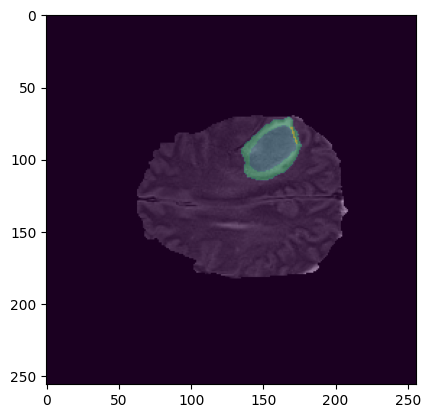

In [61]:
# This was made for previous dimension, now the dimension is changed, so need resurrection
# modality = 1
# slice_idx = 75
# plt.imshow(sample_patient['image'][:,:, slice_idx, modality], cmap='gray')
# plt.imshow(sample_patient['mask'][:,:, slice_idx], alpha=0.4)
# plt.show()

modality = 0
slice_idx = 150
plt.imshow(sample_patient['image'][modality, slice_idx, :, :], cmap='gray')
plt.imshow(sample_patient['mask'][0, slice_idx, :, :], alpha=0.4) # since channel dimension is also added on the mask volume
plt.show()

In [62]:
def plot_image_label_predictedmsk(image, label, predicted_mask, lbl): # [B, 4, D, H, W], [B, 1, D, H, W], [B, 1, D, H, W]
    # Take first sample(0), first_modality(0),  150th slice(150), 
    sample_image = image[0, 0, 150, :, :] # [H, W]

    sample_mask = label[0, 0, 150, :, :] # [H, W]
    predicted_mask = predicted_mask[0, 0, 150, :, :] # [H, W]

    print(f'------------------{lbl}------------------')
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    titles = ['Image', 'Ground Mask', 'Predicted Mask']
    for i, ax in enumerate(axes):
        ax.axis('off')  # Turn off axis lines and labels

        if i == 0:
            ax.imshow(sample_image, cmap='gray')
        elif i == 1:
            ax.imshow(sample_mask, cmap='gray')
        else:
            ax.imshow(predicted_mask, cmap='gray')
        ax.set_title(titles[i])
    plt.show()
    

In [63]:
# image = next(iter(train_loader))['image'] # [1, 4, 256, 256, 256]
# label = next(iter(train_loader))['mask'] # [1, 1, 256, 256, 256]
# predicted_mask = next(iter(train_loader))['mask'] # [1, 1, 256, 256, 256]

# plot_image_label_predictedmsk(image, label, predicted_mask)

sample_mask_slice (256, 256)


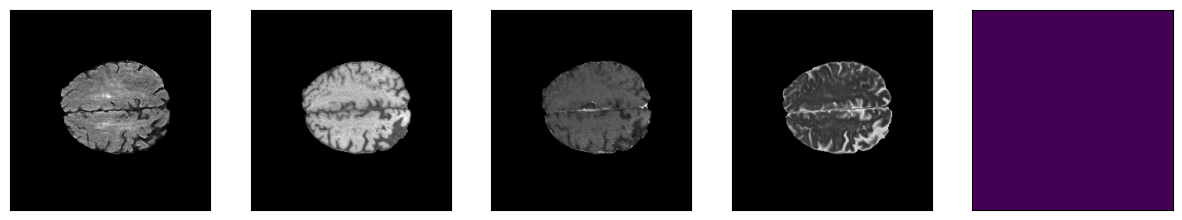

In [64]:
patient_num = random.randint(0, len(train_ds)-1) # random patient
slice_idx = 150 # Extract 15th slice

sample_image = train_ds[patient_num]['image'] # (4, 128, 240, 240)
sample_mask = train_ds[patient_num]['mask'] # (1, 128, 240, 240)
sample_image_slice = sample_image[:, slice_idx, :, :] # (4, 240, 240)
sample_mask_slice = sample_mask[0,slice_idx,:, :] # (240, 240)
print('sample_mask_slice', sample_mask_slice.shape)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
labels = []

# Iterate through first 4 modalities and display them
for i, ax in enumerate(axes[:-1]):
    ax.set_xlabel(f"")
    ax.imshow(sample_image_slice[i,:,:], cmap='gray') # prints 4 modalities of image in 4 columns
    ax.set_xticks([])
    ax.set_yticks([])

# Display the mask in last column
axes[-1].imshow(sample_mask_slice)
axes[-1].set_xticks([])
axes[-1].set_yticks([])
plt.show()


# DataLoader

In [65]:
# Create dataloader
train_loader = DataLoader(dataset=train_ds,
                          batch_size=wandb.config.train_batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_ds,
                        batch_size=wandb.config.val_batch_size, # keep batch_size same in train and val, otherwise throws error in DiceLoss (need resurrection)
                        shuffle=False,
                        drop_last=True)

Sanity Check: Iterate through dataloader and check the size

In [66]:
for batch in train_loader:
    images = batch['image']
    masks = batch['mask']
    print(f'Batch images shape {images.shape}')
    print(f'Batch masks shape {masks.shape}')
    print('--------------------')
    

Batch images shape torch.Size([1, 4, 256, 256, 256])
Batch masks shape torch.Size([1, 1, 256, 256, 256])
--------------------
Batch images shape torch.Size([1, 4, 256, 256, 256])
Batch masks shape torch.Size([1, 1, 256, 256, 256])
--------------------
Batch images shape torch.Size([1, 4, 256, 256, 256])
Batch masks shape torch.Size([1, 1, 256, 256, 256])
--------------------
Batch images shape torch.Size([1, 4, 256, 256, 256])
Batch masks shape torch.Size([1, 1, 256, 256, 256])
--------------------
Batch images shape torch.Size([1, 4, 256, 256, 256])
Batch masks shape torch.Size([1, 1, 256, 256, 256])
--------------------
Batch images shape torch.Size([1, 4, 256, 256, 256])
Batch masks shape torch.Size([1, 1, 256, 256, 256])
--------------------
Batch images shape torch.Size([1, 4, 256, 256, 256])
Batch masks shape torch.Size([1, 1, 256, 256, 256])
--------------------
Batch images shape torch.Size([1, 4, 256, 256, 256])
Batch masks shape torch.Size([1, 1, 256, 256, 256])
-------------

In [67]:
len(val_loader)

5

In [68]:
# for batch in val_loader:
#     images = batch['image']
#     masks = batch['mask']
#     print(f'Batch images shape {images.shape}')
#     print(f'Batch masks shape {masks.shape}')
#     print('--------------------')

In [69]:
len(train_loader) # Get the total number of batches. Returned 5, which means 5 batch of data each with shape(batch_size=2, 4, 155, 240, 240)


12

In [70]:
len(val_loader)

5

In [71]:
a_batch_image_mask = next(iter(train_loader))


In [72]:
a_batch_mask = a_batch_image_mask['mask']

In [73]:
a_batch_mask.shape

torch.Size([1, 1, 256, 256, 256])

In [74]:
a_mask_volume = a_batch_mask[0, :, :, :] # select first sample from the batch
a_mask_volume.shape

torch.Size([1, 256, 256, 256])

In [75]:
a_mask_slice = a_mask_volume[0, 75, :, :] # get 75th slice
a_mask_slice.shape

torch.Size([256, 256])

In [76]:
np.unique(a_mask_volume)

array([0., 1., 2., 3.], dtype=float32)

# Model

In [77]:
# Instantiate a U-Net model
model = UNet(
    spatial_dims=3,        # 3 for using 3D ConvNet and 3D Maxpooling
    in_channels=4,         # since 4 modalities
    out_channels=4,        # 4 sub-regions to segment
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
).to(my_device)
print(model)

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): Inst

In [78]:
summary(model, input_size=(4, 128, 240, 240))  # channels, depth, height, width


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 64, 120, 120]           1,744
    InstanceNorm3d-2     [-1, 16, 64, 120, 120]               0
           Dropout-3     [-1, 16, 64, 120, 120]               0
             PReLU-4     [-1, 16, 64, 120, 120]               1
            Conv3d-5       [-1, 32, 32, 60, 60]          13,856
    InstanceNorm3d-6       [-1, 32, 32, 60, 60]               0
           Dropout-7       [-1, 32, 32, 60, 60]               0
             PReLU-8       [-1, 32, 32, 60, 60]               1
            Conv3d-9       [-1, 64, 16, 30, 30]          55,360
   InstanceNorm3d-10       [-1, 64, 16, 30, 30]               0
          Dropout-11       [-1, 64, 16, 30, 30]               0
            PReLU-12       [-1, 64, 16, 30, 30]               1
           Conv3d-13       [-1, 128, 8, 15, 15]         221,312
   InstanceNorm3d-14       [-1, 128, 8,

# Training

In [79]:
def train_step(model,
               dataloader,
               loss_fn,
               dice_score,
               optimizer):
    # Putting the model in train mode
    model.train()

    # Initialize train loss and dice_score (Epoch wise)
    train_loss, train_dice_score= 0, 0

    # Loop through batches of data
    for batch_num, batch_data in enumerate(dataloader):
        X = batch_data['image'] # torch.Size([batch, 4, 128, 240, 240])
        Y = batch_data['mask'] # torch.Size([batch, 1, 128, 240, 240]) (batch, 1, 128, 240, 240) (multi-class i.e. a pixel_value ~ {0, 1, 2, 3})

        # Send data to target device
        X, Y = X.to(my_device), Y.to(my_device)

        # Forward pass
        y_pred = model(X) # y_pred shape torch.Size([batch, 4, 128, 240, 240]) # produces raw logits. 4 is due to 4 sub regions, not 4 modalities.
        
        optimizer.zero_grad() # Clear previous gradients

        # Compute and accumulate loss
        loss = loss_fn(y_pred, Y) # loss one-hot encodes the y so y will be [batch, 4, 128, 240, 240] and y_pred is [batch, 4, 128, 240, 240], loss is scalar (may be averages across modalities and batch as well)

        # Backpropagation and Optimization
        loss.backward() # Compute gradients
        optimizer.step() # Update weights
        train_loss += loss.item()

        # Log the loss for this batch
        # writer.add_scalar('batch_train_loss', train_loss, )

        with torch.no_grad():
            # Calculate and accumulate metric across the batch
            predicted_class_labels = torch.argmax(y_pred, dim=1, keepdim=True) # After argmax with keepdim=True: [batch, 1, D, H, W] {0, 1, 2, 3}, since it takes argmax along the channels(or, the #classes)
            mean_dice_score = dice_score(predicted_class_labels, Y) # average across all classes and 1 batch.
            train_dice_score += mean_dice_score

            # print(f'\n{batch_num+1:} mean_dice_score \n', mean_dice_score)

        # For predicted mask visualization, return the first batch
        if batch_num == 0:
            train_image = X.cpu() # [batch, 4, D, H, W]
            train_label = Y.cpu() # [batch, 1, D, H, W]
            train_pred = predicted_class_labels.cpu() # [batch, 1, D, H, W]

        wandb.log({
            "batch_train_loss": train_loss,
            "batch_train_dice_score": mean_dice_score,
        })
            
    # Average loss and dice_score of all batches (average of all batches = 1 epoch)
    train_loss = train_loss / len(dataloader) # average of 1 epoch
    train_dice_score = train_dice_score / len(dataloader) # average of 1 epoch

    return train_loss, train_dice_score, train_image, train_label, train_pred


In [80]:
def val_step(model,
              dataloader,
              loss_fn,
              dice_score):
    # Putting model in eval mode
    model.eval()

    # Initialize test loss
    val_loss, val_dice_score = 0, 0

    # Turn on inference context manager
    with torch.inference_mode(): # Disable gradient computation 
        # Loop through batches of data in dataloader
        for batch_num, batch_data in enumerate(dataloader):
            X = batch_data['image'] # [batch, 4, D, H, W]
            Y = batch_data['mask'] # [B, 1, D, H, W]

            # Send data to target device
            X, Y = X.to(my_device), Y.to(my_device)

            # Forward pass
            test_pred_logits = model(X) # [B, 4, 128, 240, 240]
            # print('test_pred_logits', test_pred_logits.shape)

            # Calculate and accumulate loss and dice score
            loss = loss_fn(test_pred_logits, Y)
            val_loss += loss.item()

            # Calculate and accumulate metric across the batch
            predicted_class_labels = torch.argmax(test_pred_logits, dim=1, keepdim=True) # test_pred_logits of shape [batch, 4, D, H, W] {raw logits}, after argmax [batch, D, H, W] {0, 1, 2, 3}, since it takes argmax along the channels(or, the #classes)
            # print("Val predicted_class_labels shape:", predicted_class_labels.shape) # [B, D, H, W]
            mean_dice_score = dice_score(predicted_class_labels, Y) # average across all classes and 1 batch.
            val_dice_score += mean_dice_score

            # For predicted mask visualization, return the first batch
            if batch_num == 0:
                val_image = X.cpu() # [batch, 4, D, H, W]
                val_label = Y.cpu() # [batch, 1, D, H, W]
                val_pred = predicted_class_labels.cpu() # [batch, 1, D, H, W]

            # print(f'\n{batch_num+1:} mean_dice_score:', mean_dice_score)
            wandb.log({
                "batch_val_loss": val_loss,
                "batch_val_dice_score": val_dice_score,
            })

        # Average loss and dice_score of all batches (average of all batches = 1 epoch)
        val_loss = val_loss / len(dataloader) # average of 1 epoch
        val_dice_score = val_dice_score / len(dataloader) # average of 1 epoch    

    return val_loss, val_dice_score, val_image, val_label, val_pred

In [81]:
from tqdm.auto import tqdm

# Various parameters required for training and test step
def train(model,
          checkpoint_dir,
          train_loader,
          val_loader,
          optimizer,
          loss_fn,
          dice_score,
          epochs):
    
    # Creating empty list to hold loss and accuracy
    results = {
        'train_loss':[],
        'train_dice_score':[],
        'val_loss':[],
        'val_dice_score':[]
    }

    # Looping through traininig and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_dice_score, train_image, train_label, train_pred = train_step(model=model,
                                                                                        dataloader=train_loader,
                                                                                        loss_fn=loss_fn,
                                                                                        dice_score=dice_score,
                                                                                        optimizer=optimizer)
        val_loss, val_dice_score, val_image, val_label, val_pred = val_step(model=model,
                                                                            dataloader=val_loader,
                                                                            loss_fn=loss_fn,
                                                                            dice_score=dice_score)

        writer.add_scalar("train_loss", train_loss, epoch)
        writer.add_scalar("val_loss", val_loss, epoch)
        writer.add_scalar("train_dice_score", train_dice_score, epoch)
        writer.add_scalar("val_dice_score", val_dice_score, epoch)
        
        # Print and append the loss current epoch
        wandb.log({
            "train_loss": train_loss,
            "train_dice_score": train_dice_score,
            "val_loss": val_loss,
            'val_dice_score': val_dice_score
        })

        print(
            f'Epoch: {epoch+1} --|-- '
            f'train_loss: {train_loss:.4f} --|--'
            f'val_loss: {val_loss:.4f} --|--'
            f'train_dice_score: {train_dice_score:.4f} --|--'
            f'val_dice_score: {val_dice_score:.4f} --|--'

        )
        # print('val image', val_image.shape) # [B, 4, 256, 256, 256]
        # print('val label', val_label.shape) # [B, 1, 256, 256, 256]
        # print('predicted mask', val_pred.shape) # [B, 1, 256, 256, 256]
        plot_2d_or_3d_image(train_image, epoch+1, writer, index=0, tag='train_image')
        plot_2d_or_3d_image(train_label, epoch+1, writer, index=0, tag='train_label')
        plot_2d_or_3d_image(train_pred, epoch+1, writer, index=0, tag='train_predicted_mask')

        plot_2d_or_3d_image(val_image, epoch+1, writer, index=0, tag='val_image')
        plot_2d_or_3d_image(val_label, epoch+1, writer, index=0, tag='val_label')
        plot_2d_or_3d_image(val_pred, epoch+1, writer, index=0, tag='val_predicted_mask')

        plot_image_label_predictedmsk(train_image, train_label, train_pred, lbl='Train Set')
        plot_image_label_predictedmsk(val_image, val_label, val_pred, lbl='Validation Set')
        
        # Save checkpoint
        save_checkpoint(model, checkpoint_dir, optimizer, epoch, train_loss, val_loss, train_dice_score, val_dice_score)

        # Append to the list
        results['train_loss'].append(train_loss)
        results['train_dice_score'].append(train_dice_score)
        results['val_loss'].append(val_loss)
        results['val_dice_score'].append(val_dice_score)

    return results

In [82]:
# Model name
model_name = '3DUNet'

# Generate a timestamp
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Directory to save the checkpoints
checkpoint_dir = os.path.join('checkpoints', model_name, timestamp)

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"Checkpoints will be saved in: {checkpoint_dir}")


Checkpoints will be saved in: checkpoints/3DUNet/2024-05-23_12-33-17


In [83]:
len(train_loader), len(val_loader)

(12, 5)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 --|-- train_loss: 0.8863 --|--val_loss: 0.8646 --|--train_dice_score: 0.4293 --|--val_dice_score: 0.7180 --|--
------------------Train Set------------------


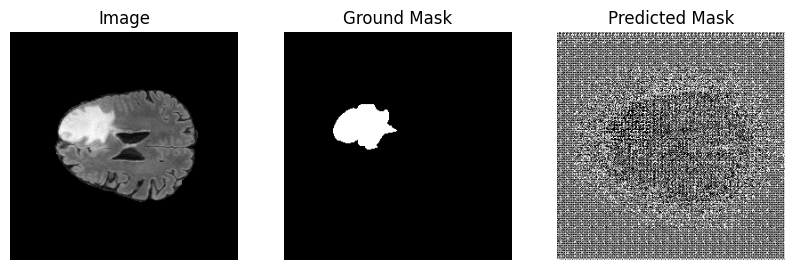

------------------Validation Set------------------


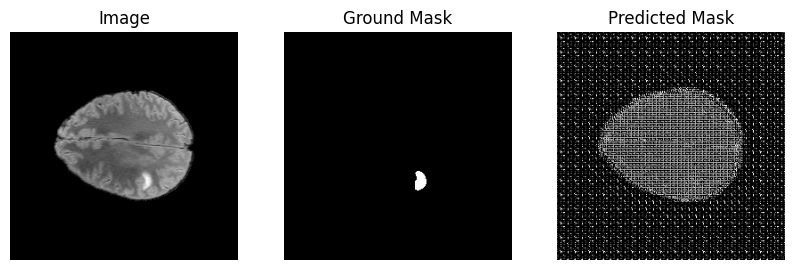

Checkpoint saved at checkpoints/3DUNet/2024-05-23_12-33-17/Epoch_1_checkpoint_2024-05-23_12-36-58.pth


In [ ]:
# Set random seeds
random_seed = wandb.config.seed
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
monai.utils.set_determinism(seed=random_seed)

# Set the number of epochs, loss function and optimizer
num_epochs = wandb.config.epochs
dice_loss = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)
# dice_metric = DiceMetric(include_background=True, reduction='Mean')
# dice_loss = DiceLoss()
dice_score = DiceScore()
optimizer = torch.optim.Adam(params=model.parameters(), lr=wandb.config.lr)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model,
                      checkpoint_dir,
                      train_loader=train_loader,
                      val_loader=val_loader,
                      optimizer=optimizer,
                      loss_fn=dice_loss,
                      dice_score=dice_score,
                      epochs=num_epochs)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")